In [1]:
train = True

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
# Mount Google Drive and set data paths.
import os
from google.colab import drive
from google.colab import files

drive.mount('/content/gdrive')

Mounted at /content/gdrive


# ML4H - Project 2

## Task 1

In [4]:
# Gloabal variables
data_path = "/content/gdrive/My Drive/ETH/MLH/Project2/data/PubMed_200k_RCT/"
model_path = "/content/gdrive/My Drive/ETH/MLH/Project2/model/"

seed = 50

In [5]:
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import pandas as pd

import numpy as np

from joblib import dump, load

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import learning_curve

from yellowbrick.model_selection import learning_curve

In [6]:
train_df = pd.read_parquet(data_path + 'pre_processed_train.gzip')
test_df = pd.read_parquet(data_path + 'pre_processed_test.gzip')
dev_df = pd.read_parquet(data_path + 'pre_processed_dev.gzip')

In [7]:
train_df.head(5)

,Label,Words
0,BACKGROUND,"[emerg, hiv, chronic, condit, mean, peopl, liv..."
1,BACKGROUND,"[paper, describ, design, evalu, posit, outlook..."
2,METHODS,"[studi, design, randomis, control, trial, men,..."
3,METHODS,"[intervent, group, particip, onlin, group, pro..."
4,METHODS,"[program, base, self, efficaci, theori, use, s..."


In [8]:
train_lab = train_df['Label']
train_words = train_df['Words']

test_lab = test_df['Label']
test_words = test_df['Words']

dev_lab = dev_df['Label']
dev_words = dev_df['Words']

In [9]:
split = [tuple([list(range(0, len(train_lab))), list(range(len(train_lab), len(train_lab) + len(dev_lab)))])]

In [10]:
# Translation of labels
le = preprocessing.LabelEncoder()
le.fit(train_lab)
print("Labels: {}".format(list(le.classes_)))

Y_train = le.transform(pd.concat([train_lab, dev_lab], ignore_index=True))
Y_test = le.transform(test_lab)

Labels: ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']


In [11]:
train_lab[0]

'BACKGROUND'

In [12]:
train_words[0]

array(['emerg', 'hiv', 'chronic', 'condit', 'mean', 'peopl', 'live',
       'hiv', 'requir', 'take', 'respons', 'self', 'manag', 'condit',
       'includ', 'make', 'physic', 'emot', 'social', 'adjust'],
      dtype=object)

In [13]:
def dummy_fun(doc):
    return doc

tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None,
    ngram_range=(1,2),
    max_df=0.5,
    min_df=100)

In [14]:
# Fitting the tfidf model
tfidf.fit(train_words)
feature_names = tfidf.get_feature_names_out()

In [15]:
print("Number of features: {}".format(len(tfidf.idf_)))

Number of features: 45643


In [16]:
X_train = tfidf.transform(pd.concat([train_words, dev_words], ignore_index=True))
X_test = tfidf.transform(test_words)

print("X_train shape is {}".format(X_train.shape))
print("X_test shape is {}".format(X_test.shape))

print("Y_train dim is {}".format(Y_train.shape[0]))
print("Y_test dim is {}".format(Y_test.shape[0]))

X_train shape is (2240793, 45643)
X_test shape is (29493, 45643)
Y_train dim is 2240793
Y_test dim is 29493


In [17]:
# Classification
clf = LinearSVC(penalty='l1', dual=False, class_weight='balanced', fit_intercept=True,
                random_state=seed, tol=1e-5)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


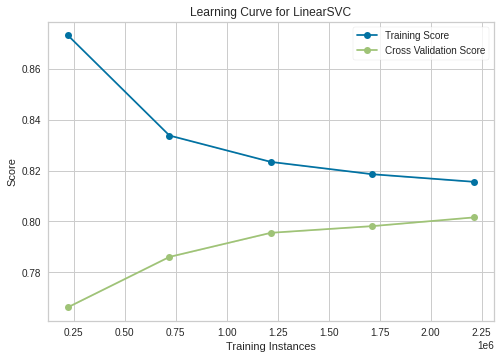

In [ ]:
# Training curve
if train:
  clf.fit(X_train, Y_train)
  dump(clf, model_path + 'svc.joblib')
  learning_curve(clf, X_train, Y_train, scoring='accuracy', cv=split) 

clf = load(model_path + 'svc.joblib') 

In [32]:
# Function to plot feature importance
def plot_feature_importance(feature_imp, feature_name, N=30):
  
  indices = np.flip(np.argsort(np.absolute(feature_imp)))

  plt.figure()
  plt.rcParams['figure.figsize'] = [10, 6]
  plt.title("Feature importances: {}".format(feature_name))
  plt.bar(range(N), np.absolute(feature_imp[indices[:N]]),
          color="r", align="center")
  plt.xticks(range(N), feature_names[indices], rotation=90)
  plt.xlim([-1, N])
  plt.show()

  print('\n')

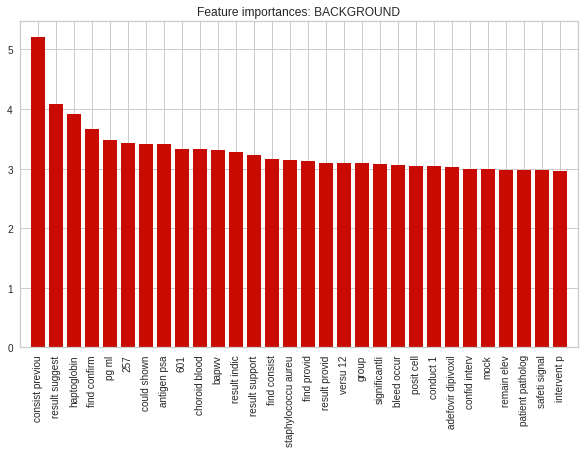

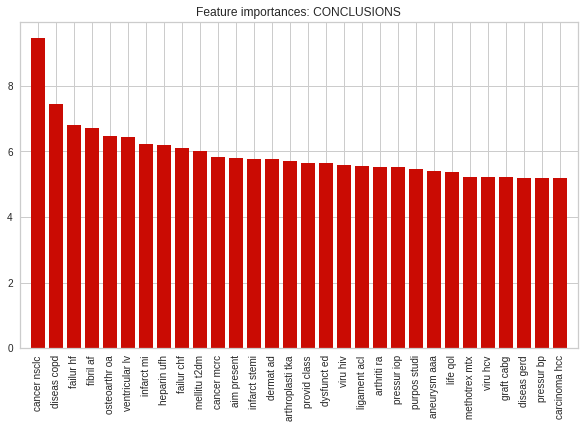

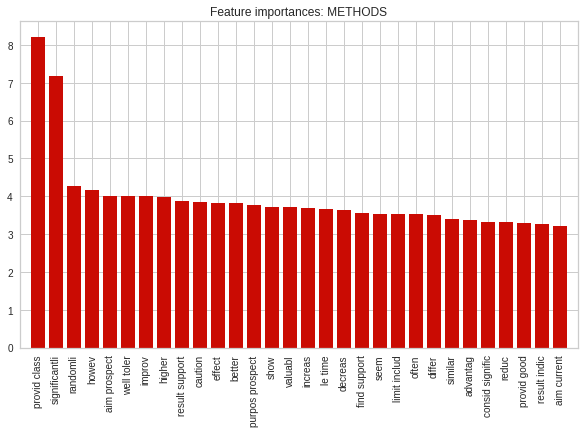

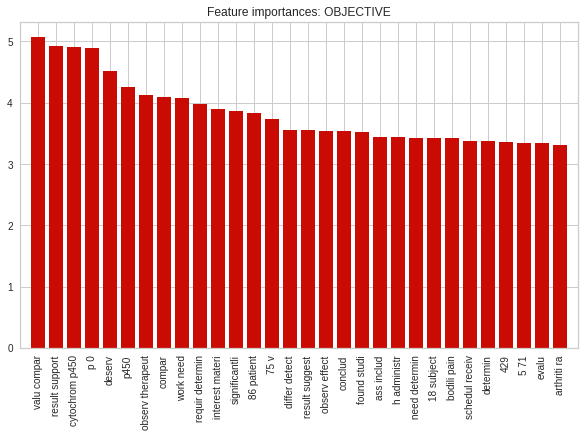

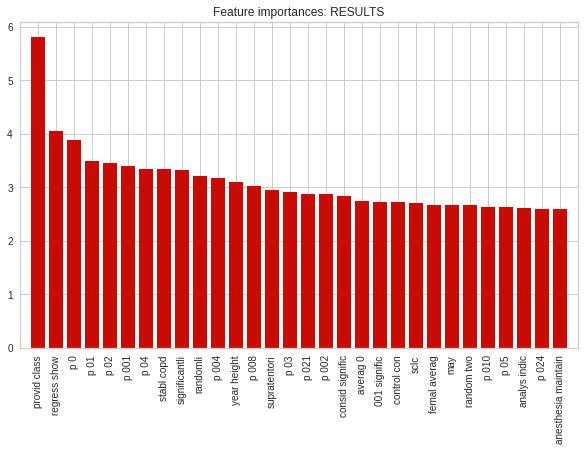

In [33]:
for i, c in enumerate(clf.coef_):
    plot_feature_importance(c, le.classes_[i])

In [26]:
def plot_importances(feature_imp, label):
  
  features = np.flip(np.sort(np.absolute(feature_imp)))
  plt.figure(figsize = (10,6))
  plt.scatter(x = range(features.shape[0]), y = features)
  plt.xlim(left = 0)
  plt.ylabel("Feature importance", size = 16)
  plt.title("Feature importance: {}".format(label), size = 20)
  plt.show()
  print('\n')

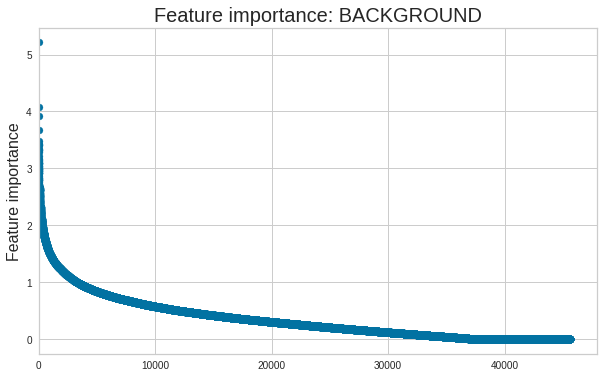

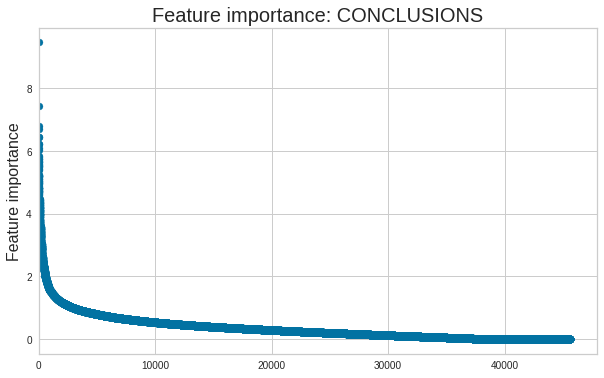

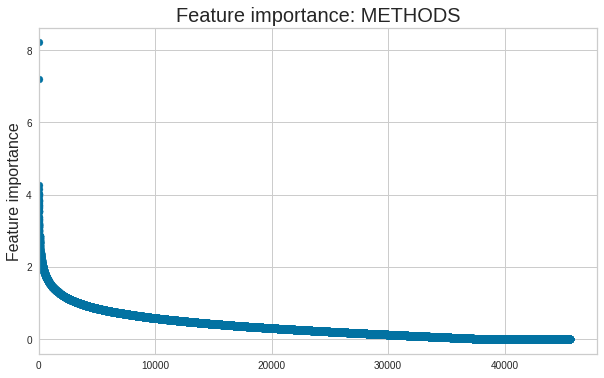

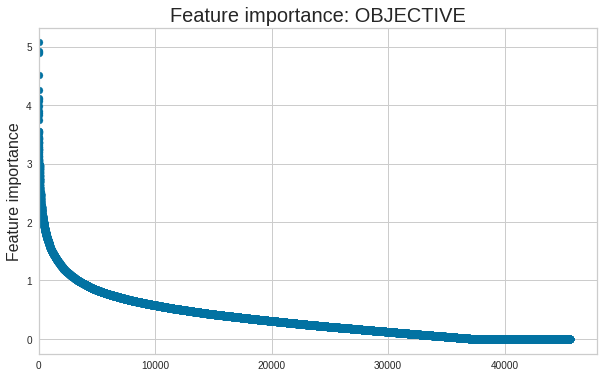

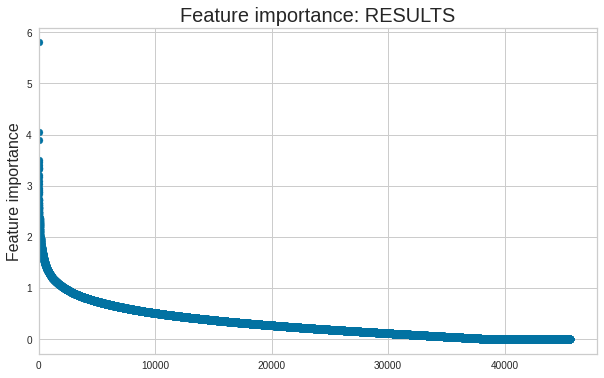

In [27]:
for i, c in enumerate(clf.coef_):
    plot_importances(c, le.classes_[i])

In [18]:
clf = load(model_path + 'svc.joblib') 

In [19]:
# Plotting scores
y_pred = clf.predict(X_test)

f1 = f1_score(Y_test, y_pred, average="macro")

print("Test f1 score : %s "% f1)

f1_w = f1_score(Y_test, y_pred, average="weighted")

print("Test f1 weighted score : %s "% f1_w)

acc = accuracy_score(Y_test, y_pred)

print("Test accuracy score : %s "% acc)

Test f1 score : 0.728901585998407 
Test f1 weighted score : 0.8010018805466524 
Test accuracy score : 0.8000203438103957 


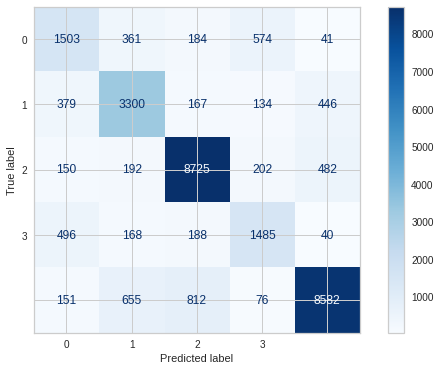

In [ ]:
# Plotting confusion matrix
cm = confusion_matrix(Y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3])

disp.plot(cmap=plt.cm.Blues)
plt.show()